In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import json
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs

import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\033[91mUsing device: {device}\033[0m")

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("cuDNN benchmark enabled for better performance")

Using device: cuda
cuDNN benchmark enabled for better performance


Made changes.

¡Perfecto! He creado el nuevo notebook `nlsperiod_loss.ipynb` con tu **Idea B: Forzar la periodicidad con una pérdida extra**.

## 🎯 ¿Qué hace este modelo?

### **Concepto Principal:**
En lugar de modificar la arquitectura de la red, este enfoque **agrega un término explícito a la función de pérdida** que fuerza que:



In [ ]:
ψ(x, 0) ≈ ψ(x, T)



### **Función de Pérdida Total:**



In [ ]:
L_total = L_IC + L_BC + L_PDE + λ_periodic · L_periodic



Donde **L_periodic** incluye:

1. **Pérdida de amplitud**: `||ψ|(t=0) - |ψ|(t=T)||²`
2. **Pérdida de parte real**: `||u(x,0) - u(x,T)||²`
3. **Pérdida de parte imaginaria**: `||v(x,0) - v(x,T)||²`

## 🔑 Características Clave:

### **Parámetro λ_periodic**
- Controla qué tan importante es la periodicidad vs. otras restricciones
- Valor por defecto: `λ = 10.0`
- Puedes ajustarlo según necesites

### **Ventajas:**
- ✅ **Más simple** que codificar el tiempo con Fourier
- ✅ **Control directo** sobre la fuerza de la periodicidad
- ✅ **No modifica la arquitectura** de la red
- ✅ **Interpretable físicamente**

### **Componentes del Notebook:**

1. **Cell 1**: Imports y configuración del dispositivo
2. **Cell 2**: Solución exacta NLS N=2
3. **Cell 3**: Red neuronal estándar
4. **Cell 4**: **Clase PeriodicLossPINN** con pérdida de periodicidad
5. **Cell 5**: Configuración del entrenamiento
6. **Cell 6**: Entrenamiento del modelo
7. **Cell 7**: Predicciones y errores
8. **Cell 8**: Verificación detallada de periodicidad
9. **Cell 9**: Visualización de resultados
10. **Cell 10**: Gráfica de periodicidad
11. **Cell 11**: Análisis de componentes de pérdida
12. **Cell 12**: Guardar resultados
13. **Cell 13**: Documentación en Markdown

## 📊 Salidas Generadas:

- `NLS_PeriodicLoss_PINN_Results.png` - Comparación de soluciones
- `NLS_PeriodicLoss_PINN_Periodicity.png` - Verificación de periodicidad
- `NLS_PeriodicLoss_PINN_Training.png` - Evolución de pérdidas
- `NLS_PeriodicLoss_PINN_results.npz` - Datos numéricos
- `NLS_PeriodicLoss_PINN_metadata.json` - Metadatos del modelo

Ahora puedes ejecutar todas las celdas y ver cómo el modelo aprende a ser periódico mediante la pérdida explícita! 🚀

In [2]:
def nls_solution_N2_fast():
    """
    Solución exacta de la ecuación NLS para N=2 (2 solitones)
    Extendida a t ∈ [0, 2π] para verificar periodicidad
    """
    # Dominio extendido
    x = np.linspace(-5, 5, 256)
    t = np.linspace(0, 2*np.pi, 201)
    
    X, T = np.meshgrid(x, t, indexing='ij')
    
    # Solución vectorizada para N=2 (Satsuma-Yajima)
    numerator = 4 * (np.cosh(3*X) + 3 * np.exp(4j*T) * np.cosh(X)) * np.exp(0.5j*T)
    denominator = np.cosh(4*X) + 4 * np.cosh(2*X) + 3 * np.cos(4*T)
    
    psi = numerator / denominator
    
    return x, t, psi

# Generar datos de entrenamiento
x, t, psi = nls_solution_N2_fast()

# Extraer partes real e imaginaria
Exact_u = np.real(psi)
Exact_v = np.imag(psi)
Exact_h = np.abs(psi)

print(f"Dominio espacial: x ∈ [{x.min():.1f}, {x.max():.1f}]")
print(f"Dominio temporal: t ∈ [{t.min():.1f}, {t.max():.1f}]")
print(f"Forma de la solución: {psi.shape}")

Dominio espacial: x ∈ [-5.0, 5.0]
Dominio temporal: t ∈ [0.0, 6.3]
Forma de la solución: (256, 201)


In [3]:
class NeuralNetwork(nn.Module):
    """
    Red neuronal estándar con arquitectura profunda
    """
    def __init__(self, layers):
        super(NeuralNetwork, self).__init__()
        
        self.depth = len(layers) - 1
        self.activation = nn.Tanh()
        
        layer_list = []
        for i in range(self.depth):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            nn.init.xavier_normal_(layer_list[i].weight)
            nn.init.zeros_(layer_list[i].bias)
            
        self.layers = nn.ModuleList(layer_list)
    
    def forward(self, x):
        for i in range(self.depth - 1):
            x = self.activation(self.layers[i](x))
        
        # Última capa sin activación
        x = self.layers[-1](x)
        return x

In [4]:
class PeriodicLossPINN:
    """
    Physics-Informed Neural Network con pérdida explícita de periodicidad:
    Fuerza que ψ(x, 0) ≈ ψ(x, T) añadiendo un término a la función de pérdida
    """
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, T_period=2*np.pi, lambda_periodic=10.0):
        
        # Condiciones iniciales
        self.x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        self.t0 = torch.tensor(np.zeros_like(x0), dtype=torch.float32).to(device)
        self.u0 = torch.tensor(u0, dtype=torch.float32).to(device)
        self.v0 = torch.tensor(v0, dtype=torch.float32).to(device)
        
        # Condiciones de frontera espaciales
        self.x_lb = torch.tensor(lb[0] * np.ones_like(tb), dtype=torch.float32).to(device)
        self.t_lb = torch.tensor(tb, dtype=torch.float32).to(device)
        
        self.x_ub = torch.tensor(ub[0] * np.ones_like(tb), dtype=torch.float32).to(device)
        self.t_ub = torch.tensor(tb, dtype=torch.float32).to(device)
        
        # Puntos de colocación
        self.x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32).to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], dtype=torch.float32).to(device)
        
        # Límites del dominio
        self.lb = torch.tensor(lb, dtype=torch.float32).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float32).to(device)
        
        # Periodo temporal y peso de la pérdida periódica
        self.T_period = T_period
        self.lambda_periodic = lambda_periodic
        
        # Puntos para evaluar la periodicidad temporal
        # Usamos los mismos puntos x0 para comparar t=0 vs t=T
        self.x_periodic = self.x0.clone()
        self.t_T = torch.tensor(T_period * np.ones_like(x0), dtype=torch.float32).to(device)
        
        # Inicializar la red neuronal
        self.layers = layers
        self.model = NeuralNetwork(layers).to(device)
        
        # Optimizadores
        self.optimizer_adam = optim.Adam(self.model.parameters(), lr=0.001)
        self.optimizer_lbfgs = optim.LBFGS(
            self.model.parameters(), 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50, 
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )
        
        # Historial de pérdidas
        self.loss_adam = []
        self.loss_lbfgs = []
        self.loss_components_history = {'ic': [], 'bc': [], 'pde': [], 'periodic': []}
        self.iteration = 0
    
    def net_uv(self, x, t):
        """
        Predicción de u y v usando la red neuronal
        """
        # Normalizar entradas a [-1, 1]
        X = torch.cat([x, t], dim=1)
        X_normalized = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        
        # Forward pass
        uv = self.model(X_normalized)
        u, v = uv[:, 0:1], uv[:, 1:2]
        
        return u, v
    
    def net_f_uv(self, x, t):
        """
        Residuales de la ecuación NLS:
        i ∂ψ/∂t + 0.5 ∂²ψ/∂x² + |ψ|² ψ = 0
        """
        x = x.clone().detach().requires_grad_(True)
        t = t.clone().detach().requires_grad_(True)
        
        u, v = self.net_uv(x, t)
        
        # Derivadas de u
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                 retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                 retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                  retain_graph=True, create_graph=True)[0]
        
        # Derivadas de v
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v),
                                 retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v),
                                 retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x),
                                  retain_graph=True, create_graph=True)[0]
        
        # Ecuación NLS
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u
        
        return f_u, f_v
    
    def loss_fn(self):
        """
        Función de pérdida total con término de periodicidad temporal explícito
        """
        # 1. Pérdida de condición inicial
        u_pred0, v_pred0 = self.net_uv(self.x0, self.t0)
        loss_u0 = torch.mean((self.u0 - u_pred0)**2)
        loss_v0 = torch.mean((self.v0 - v_pred0)**2)
        loss_ic = loss_u0 + loss_v0
        
        # 2. Pérdida de condiciones de frontera espaciales (periódicas)
        u_lb, v_lb = self.net_uv(self.x_lb, self.t_lb)
        u_ub, v_ub = self.net_uv(self.x_ub, self.t_ub)
        
        loss_u_bnd = torch.mean((u_lb - u_ub)**2)
        loss_v_bnd = torch.mean((v_lb - v_ub)**2)
        
        # Periodicidad de derivadas espaciales
        x_lb = self.x_lb.clone().detach().requires_grad_(True)
        t_lb = self.t_lb.clone().detach().requires_grad_(True)
        u_lb, v_lb = self.net_uv(x_lb, t_lb)
        
        u_x_lb = torch.autograd.grad(u_lb, x_lb, grad_outputs=torch.ones_like(u_lb),
                                    retain_graph=True, create_graph=True)[0]
        v_x_lb = torch.autograd.grad(v_lb, x_lb, grad_outputs=torch.ones_like(v_lb),
                                    retain_graph=True, create_graph=True)[0]
        
        x_ub = self.x_ub.clone().detach().requires_grad_(True)
        t_ub = self.t_ub.clone().detach().requires_grad_(True)
        u_ub, v_ub = self.net_uv(x_ub, t_ub)
        
        u_x_ub = torch.autograd.grad(u_ub, x_ub, grad_outputs=torch.ones_like(u_ub),
                                    retain_graph=True, create_graph=True)[0]
        v_x_ub = torch.autograd.grad(v_ub, x_ub, grad_outputs=torch.ones_like(v_ub),
                                    retain_graph=True, create_graph=True)[0]
        
        loss_u_x_bnd = torch.mean((u_x_lb - u_x_ub)**2)
        loss_v_x_bnd = torch.mean((v_x_lb - v_x_ub)**2)
        
        loss_bc = loss_u_bnd + loss_v_bnd + loss_u_x_bnd + loss_v_x_bnd
        
        # 3. Pérdida de residuales de la PDE
        f_u, f_v = self.net_f_uv(self.x_f, self.t_f)
        loss_f_u = torch.mean(f_u**2)
        loss_f_v = torch.mean(f_v**2)
        loss_pde = loss_f_u + loss_f_v
        
        # 4. ⭐ PÉRDIDA DE PERIODICIDAD TEMPORAL ⭐
        # Forzar que ψ(x, 0) ≈ ψ(x, T)
        u_t0, v_t0 = self.net_uv(self.x_periodic, self.t0)
        u_tT, v_tT = self.net_uv(self.x_periodic, self.t_T)
        
        # Pérdida en amplitud (magnitud)
        h_t0 = torch.sqrt(u_t0**2 + v_t0**2 + 1e-8)
        h_tT = torch.sqrt(u_tT**2 + v_tT**2 + 1e-8)
        loss_periodic_amplitude = torch.mean((h_t0 - h_tT)**2)
        
        # Pérdida en fase (diferencia compleja)
        # También podemos forzar que las partes real e imaginaria coincidan
        loss_periodic_real = torch.mean((u_t0 - u_tT)**2)
        loss_periodic_imag = torch.mean((v_t0 - v_tT)**2)
        
        # Pérdida periódica total (combinación de amplitud y fase)
        loss_periodic = loss_periodic_amplitude + loss_periodic_real + loss_periodic_imag
        
        # Pérdida total ponderada
        loss_total = loss_ic + loss_bc + loss_pde + self.lambda_periodic * loss_periodic
        
        # Guardar componentes para análisis
        self.loss_components_history['ic'].append(loss_ic.item())
        self.loss_components_history['bc'].append(loss_bc.item())
        self.loss_components_history['pde'].append(loss_pde.item())
        self.loss_components_history['periodic'].append(loss_periodic.item())
        
        return loss_total
    
    def closure(self):
        self.optimizer_lbfgs.zero_grad()
        loss = self.loss_fn()
        loss.backward()
        self.iteration += 1
        if self.iteration % 100 == 0:
            print(f'Iteration {self.iteration}: Loss L-BFGS = {loss.item():.5e}')
        self.loss_lbfgs.append(loss.item())
        return loss
    
    def train(self, epochs_adam):
        self.model.train()
        
        # Fase 1: Optimización con Adam
        print("=" * 60)
        print("Fase 1: Optimización con Adam")
        print(f"λ_periodic = {self.lambda_periodic}")
        print("=" * 60)
        start_time = time.time()
        
        for epoch in range(epochs_adam):
            self.optimizer_adam.zero_grad()
            loss = self.loss_fn()
            loss.backward()
            self.optimizer_adam.step()
            
            self.loss_adam.append(loss.item())
            
            if epoch % 100 == 0:
                elapsed = time.time() - start_time
                periodic_loss = self.loss_components_history['periodic'][-1]
                print(f'Epoch {epoch}/{epochs_adam}, Loss Total: {loss.item():.5e}, '
                      f'Loss Periodic: {periodic_loss:.5e}, Time: {elapsed:.2f}s')
                start_time = time.time()
        
        # Fase 2: Refinamiento con L-BFGS
        print("\n" + "=" * 60)
        print("Fase 2: Refinamiento con L-BFGS")
        print("=" * 60)
        self.iteration = 0
        self.optimizer_lbfgs.step(self.closure)
        
        print('\n¡Entrenamiento completado!')
    
    def predict(self, X_star):
        self.model.eval()
        
        x = torch.tensor(X_star[:, 0:1], dtype=torch.float32).to(device)
        t = torch.tensor(X_star[:, 1:2], dtype=torch.float32).to(device)
        
        with torch.no_grad():
            u, v = self.net_uv(x, t)
        
        return u.cpu().numpy(), v.cpu().numpy()

In [5]:
# =====================================================================
# CONFIGURACIÓN DEL ENTRENAMIENTO
# =====================================================================

# Dominio
lb = np.array([-5.0, 0.0])      # [x_min, t_min]
ub = np.array([5.0, 2*np.pi])   # [x_max, t_max] - Extendido a 2π
T_period = 2 * np.pi            # Periodo temporal

# Parámetros de muestreo
N0 = 150        # Puntos de condición inicial
N_b = 150       # Puntos de frontera
N_f = 20000     # Puntos de colocación

# Arquitectura de la red (entrada estándar: [x, t])
layers = [2, 80, 80, 80, 80, 2]

# ⭐ Parámetro clave: peso de la pérdida de periodicidad
lambda_periodic = 10.0  # Ajusta este valor para controlar la importancia

print(f"\n{'='*60}")
print(f"PINN CON PÉRDIDA EXPLÍCITA DE PERIODICIDAD")
print(f"{'='*60}")
print(f"Periodo temporal: T = {T_period:.4f}")
print(f"Peso de pérdida periódica: λ = {lambda_periodic}")
print(f"Arquitectura: {layers}")
print(f"Puntos IC: {N0}, BC: {N_b}, Colocación: {N_f}")
print(f"{'='*60}\n")

# =====================================================================
# PREPARAR DATOS DE ENTRENAMIENTO
# =====================================================================

# Reshape de arrays
x_flat = x.flatten()[:, None]
t_flat = t.flatten()[:, None]

# Condición inicial: t=0
idx_x = np.random.choice(x_flat.shape[0], N0, replace=False)
x0 = x_flat[idx_x, :]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

print(f"Condición inicial: {x0.shape[0]} puntos en t=0")

# Condiciones de frontera espaciales
idx_t = np.random.choice(t_flat.shape[0], N_b, replace=False)
tb = t_flat[idx_t, :]

print(f"Condiciones de frontera: {tb.shape[0]} puntos en cada borde")

# Puntos de colocación
X_f = lb + (ub - lb) * lhs(2, N_f)

print(f"Puntos de colocación: {X_f.shape[0]} puntos")
print(f"\nDatos de entrenamiento preparados.\n")


PINN CON PÉRDIDA EXPLÍCITA DE PERIODICIDAD
Periodo temporal: T = 6.2832
Peso de pérdida periódica: λ = 10.0
Arquitectura: [2, 80, 80, 80, 80, 2]
Puntos IC: 150, BC: 150, Colocación: 20000

Condición inicial: 150 puntos en t=0
Condiciones de frontera: 150 puntos en cada borde
Puntos de colocación: 20000 puntos

Datos de entrenamiento preparados.



In [6]:
# =====================================================================
# ENTRENAR EL MODELO
# =====================================================================

# Crear el modelo con pérdida de periodicidad explícita
model = PeriodicLossPINN(
    x0, u0, v0, tb, X_f, 
    layers, lb, ub, 
    T_period=T_period,
    lambda_periodic=lambda_periodic
)

# Entrenar
start_time = time.time()
model.train(epochs_adam=20000)
elapsed = time.time() - start_time

print(f"\n{'='*60}")
print(f"Tiempo total de entrenamiento: {elapsed:.2f} segundos ({elapsed/60:.2f} minutos)")
print(f"{'='*60}\n")

Fase 1: Optimización con Adam
λ_periodic = 10.0
Epoch 0/20000, Loss Total: 2.07720e+00, Loss Periodic: 9.66441e-02, Time: 0.23s
Epoch 100/20000, Loss Total: 4.12503e-01, Loss Periodic: 2.41351e-04, Time: 2.36s
Epoch 200/20000, Loss Total: 3.61655e-01, Loss Periodic: 3.71864e-04, Time: 2.34s
Epoch 300/20000, Loss Total: 2.25877e-01, Loss Periodic: 1.94405e-04, Time: 2.36s
Epoch 400/20000, Loss Total: 2.17013e-01, Loss Periodic: 2.12014e-04, Time: 2.59s
Epoch 500/20000, Loss Total: 2.01034e-01, Loss Periodic: 7.14894e-04, Time: 2.69s
Epoch 600/20000, Loss Total: 1.72332e-01, Loss Periodic: 1.10999e-04, Time: 2.59s
Epoch 700/20000, Loss Total: 1.57649e-01, Loss Periodic: 1.25322e-04, Time: 2.51s
Epoch 800/20000, Loss Total: 1.49614e-01, Loss Periodic: 1.37734e-04, Time: 2.14s
Epoch 900/20000, Loss Total: 1.38630e-01, Loss Periodic: 1.14893e-04, Time: 2.20s
Epoch 1000/20000, Loss Total: 1.31793e-01, Loss Periodic: 1.28430e-04, Time: 2.27s
Epoch 1100/20000, Loss Total: 1.30391e-01, Loss Per

In [13]:
# =====================================================================
# PREDICCIONES Y EVALUACIÓN
# =====================================================================

# Crear malla para predicción
X_mesh, T_mesh = np.meshgrid(x, t)
X_star = np.hstack((X_mesh.flatten()[:, None], T_mesh.flatten()[:, None]))

# Datos exactos
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]

print("Generando predicciones...")
u_pred, v_pred = model.predict(X_star)

# Calcular magnitud
h_pred = np.sqrt(u_pred**2 + v_pred**2)

# Errores relativos L2
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_h = np.linalg.norm(h_star - h_pred, 2) / np.linalg.norm(h_star, 2)

print(f"\n{'='*60}")
print(f"ERRORES RELATIVOS L2")
print(f"{'='*60}")
print(f"Error u (parte real):       {error_u:.6e}")
print(f"Error v (parte imaginaria): {error_v:.6e}")
print(f"Error h (magnitud):         {error_h:.6e}")
print(f"{'='*60}\n")

# Reshape para visualización
U_pred = u_pred.reshape(t.shape[0], x.shape[0])
V_pred = v_pred.reshape(t.shape[0], x.shape[0])
H_pred = h_pred.reshape(t.shape[0], x.shape[0])

Generando predicciones...

ERRORES RELATIVOS L2
Error u (parte real):       1.322928e+00
Error v (parte imaginaria): 1.351381e+00
Error h (magnitud):         4.958299e-01



In [8]:
# =====================================================================
# VERIFICACIÓN DETALLADA DE PERIODICIDAD
# =====================================================================

print(f"\n{'='*60}")
print(f"VERIFICACIÓN DE PERIODICIDAD TEMPORAL")
print(f"{'='*60}\n")

# Comparar solución en t=0 y t=2π
t0_idx = 0
t_final_idx = -1

# Solución exacta
u_t0_exact = Exact_u[:, t0_idx]
u_t2pi_exact = Exact_u[:, t_final_idx]
v_t0_exact = Exact_v[:, t0_idx]
v_t2pi_exact = Exact_v[:, t_final_idx]
h_t0_exact = Exact_h[:, t0_idx]
h_t2pi_exact = Exact_h[:, t_final_idx]

# Predicción del modelo
u_t0_pred = U_pred[t0_idx, :]
u_t2pi_pred = U_pred[t_final_idx, :]
v_t0_pred = V_pred[t0_idx, :]
v_t2pi_pred = V_pred[t_final_idx, :]
h_t0_pred = H_pred[t0_idx, :]
h_t2pi_pred = H_pred[t_final_idx, :]

# Errores de periodicidad
periodicity_error_u_exact = np.linalg.norm(u_t0_exact - u_t2pi_exact) / np.linalg.norm(u_t0_exact)
periodicity_error_u_pred = np.linalg.norm(u_t0_pred - u_t2pi_pred) / np.linalg.norm(u_t0_pred)

periodicity_error_v_exact = np.linalg.norm(v_t0_exact - v_t2pi_exact) / np.linalg.norm(v_t0_exact)
periodicity_error_v_pred = np.linalg.norm(v_t0_pred - v_t2pi_pred) / np.linalg.norm(v_t0_pred)

periodicity_error_h_exact = np.linalg.norm(h_t0_exact - h_t2pi_exact) / np.linalg.norm(h_t0_exact)
periodicity_error_h_pred = np.linalg.norm(h_t0_pred - h_t2pi_pred) / np.linalg.norm(h_t0_pred)

print("Errores de periodicidad (solución exacta):")
print(f"  u: {periodicity_error_u_exact:.6e}")
print(f"  v: {periodicity_error_v_exact:.6e}")
print(f"  |ψ|: {periodicity_error_h_exact:.6e}")

print("\nErrores de periodicidad (PINN con pérdida explícita):")
print(f"  u: {periodicity_error_u_pred:.6e}")
print(f"  v: {periodicity_error_v_pred:.6e}")
print(f"  |ψ|: {periodicity_error_h_pred:.6e}")

print(f"\n{'='*60}\n")


VERIFICACIÓN DE PERIODICIDAD TEMPORAL

Errores de periodicidad (solución exacta):
  u: 2.000000e+00
  v: inf
  |ψ|: 0.000000e+00

Errores de periodicidad (PINN con pérdida explícita):
  u: 5.234891e-03
  v: 7.106763e-02
  |ψ|: 5.214638e-03




C:\Users\magdi\AppData\Local\Temp\ipykernel_18808\1598685607.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  periodicity_error_v_exact = np.linalg.norm(v_t0_exact - v_t2pi_exact) / np.linalg.norm(v_t0_exact)


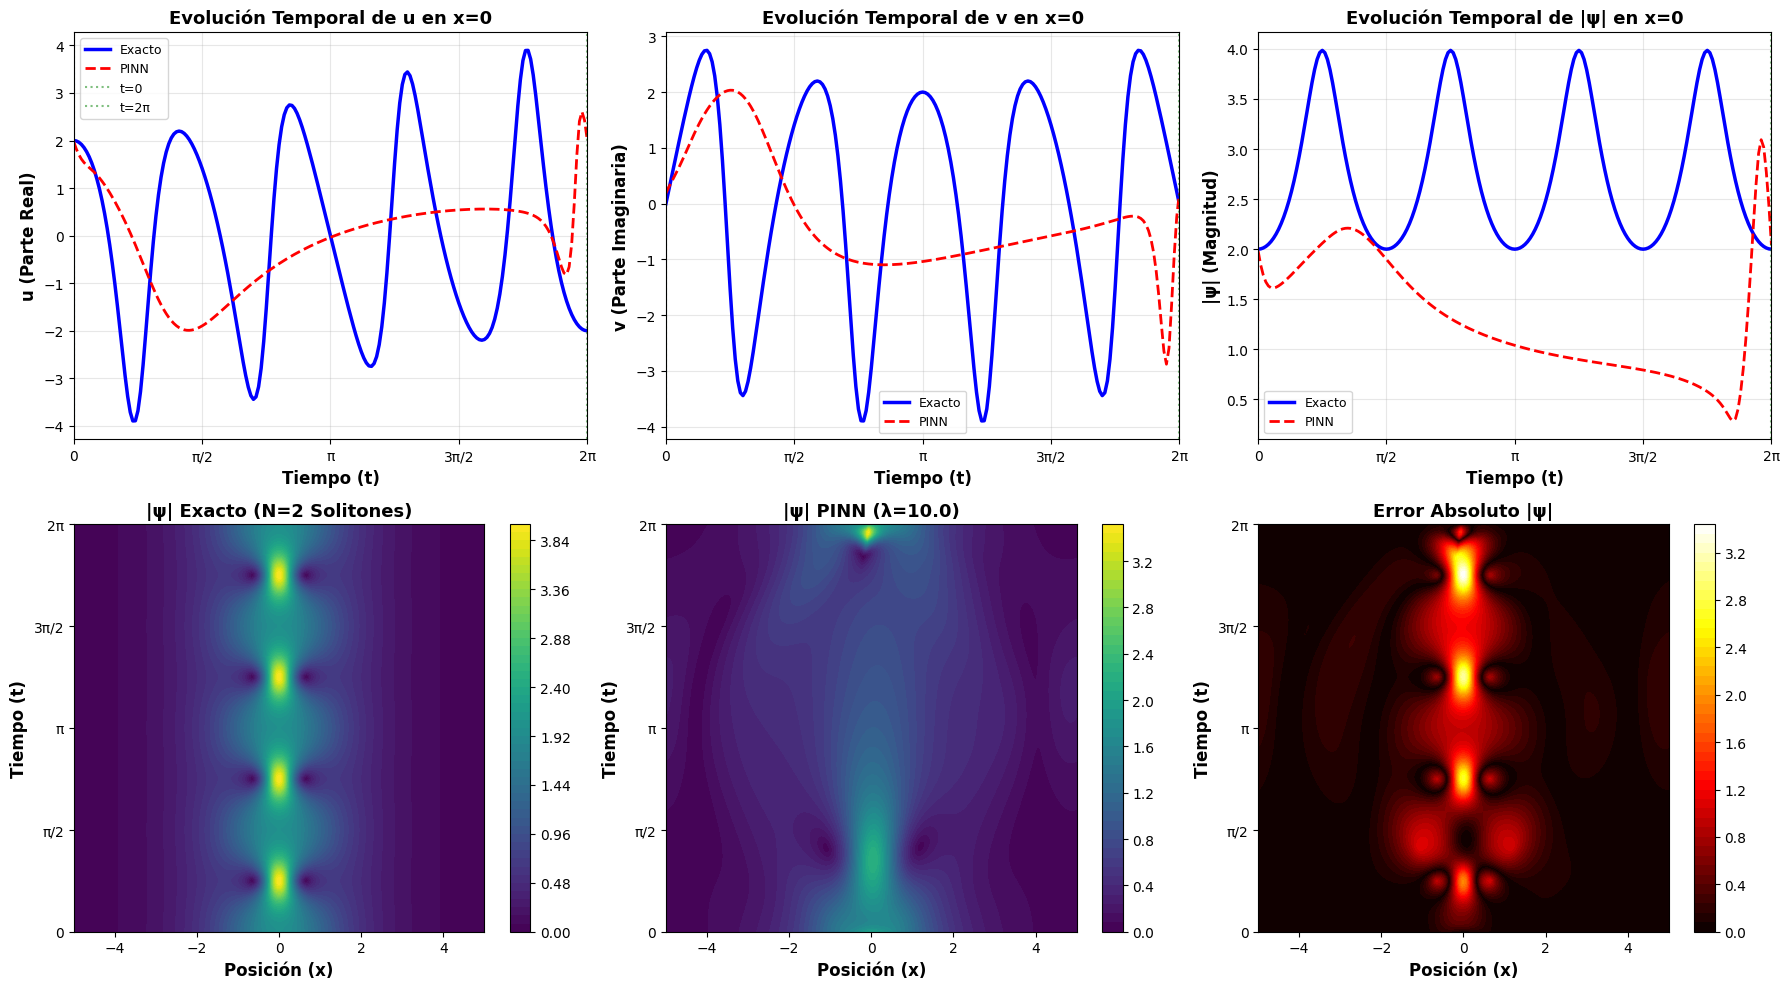

Gráfica guardada: NLS_PeriodicLoss_PINN_Results.png


In [9]:
# =====================================================================
# VISUALIZACIÓN DE RESULTADOS
# =====================================================================

fig = plt.figure(figsize=(18, 10))

# Punto central en x=0
central_idx = np.argmin(np.abs(x))

# -------- Fila 1: Evolución temporal en x=0 --------
ax1 = plt.subplot(2, 3, 1)
ax1.plot(t, Exact_u[central_idx, :], 'b-', linewidth=2.5, label='Exacto')
ax1.plot(t, U_pred[:, central_idx], 'r--', linewidth=2, label='PINN')
ax1.axvline(x=0, color='green', linestyle=':', alpha=0.5, label='t=0')
ax1.axvline(x=2*np.pi, color='green', linestyle=':', alpha=0.5, label='t=2π')
ax1.set_xlabel('Tiempo (t)', fontsize=12, fontweight='bold')
ax1.set_ylabel('u (Parte Real)', fontsize=12, fontweight='bold')
ax1.set_title('Evolución Temporal de u en x=0', fontsize=13, fontweight='bold')
ax1.legend(frameon=True, fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2*np.pi)
ax1.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

ax2 = plt.subplot(2, 3, 2)
ax2.plot(t, Exact_v[central_idx, :], 'b-', linewidth=2.5, label='Exacto')
ax2.plot(t, V_pred[:, central_idx], 'r--', linewidth=2, label='PINN')
ax2.axvline(x=0, color='green', linestyle=':', alpha=0.5)
ax2.axvline(x=2*np.pi, color='green', linestyle=':', alpha=0.5)
ax2.set_xlabel('Tiempo (t)', fontsize=12, fontweight='bold')
ax2.set_ylabel('v (Parte Imaginaria)', fontsize=12, fontweight='bold')
ax2.set_title('Evolución Temporal de v en x=0', fontsize=13, fontweight='bold')
ax2.legend(frameon=True, fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 2*np.pi)
ax2.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax2.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

ax3 = plt.subplot(2, 3, 3)
ax3.plot(t, Exact_h[central_idx, :], 'b-', linewidth=2.5, label='Exacto')
ax3.plot(t, H_pred[:, central_idx], 'r--', linewidth=2, label='PINN')
ax3.axvline(x=0, color='green', linestyle=':', alpha=0.5)
ax3.axvline(x=2*np.pi, color='green', linestyle=':', alpha=0.5)
ax3.set_xlabel('Tiempo (t)', fontsize=12, fontweight='bold')
ax3.set_ylabel('|ψ| (Magnitud)', fontsize=12, fontweight='bold')
ax3.set_title('Evolución Temporal de |ψ| en x=0', fontsize=13, fontweight='bold')
ax3.legend(frameon=True, fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 2*np.pi)
ax3.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax3.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

# -------- Fila 2: Mapas de calor --------
ax4 = plt.subplot(2, 3, 4)
im1 = ax4.contourf(X_mesh, T_mesh, Exact_h.T, levels=50, cmap='viridis')
ax4.set_xlabel('Posición (x)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Tiempo (t)', fontsize=12, fontweight='bold')
ax4.set_title('|ψ| Exacto (N=2 Solitones)', fontsize=13, fontweight='bold')
ax4.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax4.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
plt.colorbar(im1, ax=ax4)

ax5 = plt.subplot(2, 3, 5)
im2 = ax5.contourf(X_mesh, T_mesh, H_pred, levels=50, cmap='viridis')
ax5.set_xlabel('Posición (x)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Tiempo (t)', fontsize=12, fontweight='bold')
ax5.set_title(f'|ψ| PINN (λ={lambda_periodic})', fontsize=13, fontweight='bold')
ax5.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax5.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
plt.colorbar(im2, ax=ax5)

ax6 = plt.subplot(2, 3, 6)
error_map = np.abs(Exact_h.T - H_pred)
im3 = ax6.contourf(X_mesh, T_mesh, error_map, levels=50, cmap='hot')
ax6.set_xlabel('Posición (x)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Tiempo (t)', fontsize=12, fontweight='bold')
ax6.set_title('Error Absoluto |ψ|', fontsize=13, fontweight='bold')
ax6.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax6.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
plt.colorbar(im3, ax=ax6)

plt.tight_layout()
plt.savefig('NLS_PeriodicLoss_PINN_Results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: NLS_PeriodicLoss_PINN_Results.png")

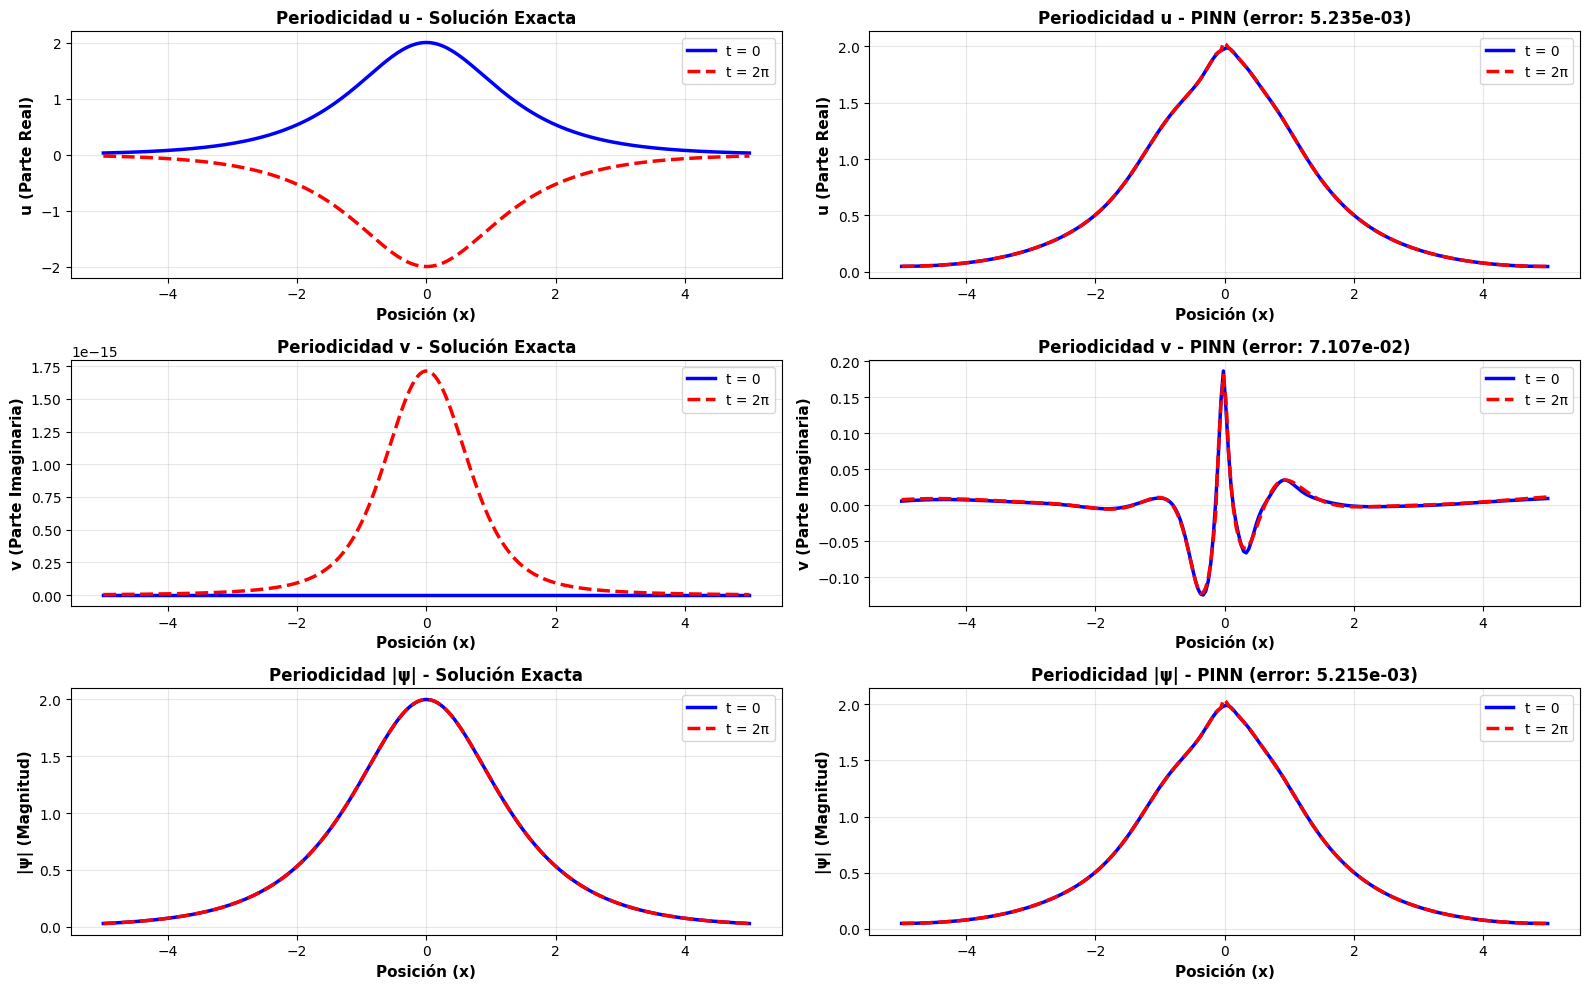

Gráfica guardada: NLS_PeriodicLoss_PINN_Periodicity.png


In [10]:
# =====================================================================
# GRÁFICA DE VERIFICACIÓN DE PERIODICIDAD
# =====================================================================

fig = plt.figure(figsize=(16, 10))

# Fila 1: Comparación de u
ax1 = plt.subplot(3, 2, 1)
ax1.plot(x, u_t0_exact, 'b-', linewidth=2.5, label='t = 0')
ax1.plot(x, u_t2pi_exact, 'r--', linewidth=2.5, label='t = 2π')
ax1.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax1.set_ylabel('u (Parte Real)', fontsize=11, fontweight='bold')
ax1.set_title('Periodicidad u - Solución Exacta', fontsize=12, fontweight='bold')
ax1.legend(frameon=True, fontsize=10)
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 2, 2)
ax2.plot(x, u_t0_pred, 'b-', linewidth=2.5, label='t = 0')
ax2.plot(x, u_t2pi_pred, 'r--', linewidth=2.5, label='t = 2π')
ax2.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax2.set_ylabel('u (Parte Real)', fontsize=11, fontweight='bold')
ax2.set_title(f'Periodicidad u - PINN (error: {periodicity_error_u_pred:.3e})', fontsize=12, fontweight='bold')
ax2.legend(frameon=True, fontsize=10)
ax2.grid(True, alpha=0.3)

# Fila 2: Comparación de v
ax3 = plt.subplot(3, 2, 3)
ax3.plot(x, v_t0_exact, 'b-', linewidth=2.5, label='t = 0')
ax3.plot(x, v_t2pi_exact, 'r--', linewidth=2.5, label='t = 2π')
ax3.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax3.set_ylabel('v (Parte Imaginaria)', fontsize=11, fontweight='bold')
ax3.set_title('Periodicidad v - Solución Exacta', fontsize=12, fontweight='bold')
ax3.legend(frameon=True, fontsize=10)
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(3, 2, 4)
ax4.plot(x, v_t0_pred, 'b-', linewidth=2.5, label='t = 0')
ax4.plot(x, v_t2pi_pred, 'r--', linewidth=2.5, label='t = 2π')
ax4.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax4.set_ylabel('v (Parte Imaginaria)', fontsize=11, fontweight='bold')
ax4.set_title(f'Periodicidad v - PINN (error: {periodicity_error_v_pred:.3e})', fontsize=12, fontweight='bold')
ax4.legend(frameon=True, fontsize=10)
ax4.grid(True, alpha=0.3)

# Fila 3: Comparación de |ψ|
ax5 = plt.subplot(3, 2, 5)
ax5.plot(x, h_t0_exact, 'b-', linewidth=2.5, label='t = 0')
ax5.plot(x, h_t2pi_exact, 'r--', linewidth=2.5, label='t = 2π')
ax5.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax5.set_ylabel('|ψ| (Magnitud)', fontsize=11, fontweight='bold')
ax5.set_title('Periodicidad |ψ| - Solución Exacta', fontsize=12, fontweight='bold')
ax5.legend(frameon=True, fontsize=10)
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 2, 6)
ax6.plot(x, h_t0_pred, 'b-', linewidth=2.5, label='t = 0')
ax6.plot(x, h_t2pi_pred, 'r--', linewidth=2.5, label='t = 2π')
ax6.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax6.set_ylabel('|ψ| (Magnitud)', fontsize=11, fontweight='bold')
ax6.set_title(f'Periodicidad |ψ| - PINN (error: {periodicity_error_h_pred:.3e})', fontsize=12, fontweight='bold')
ax6.legend(frameon=True, fontsize=10)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NLS_PeriodicLoss_PINN_Periodicity.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: NLS_PeriodicLoss_PINN_Periodicity.png")

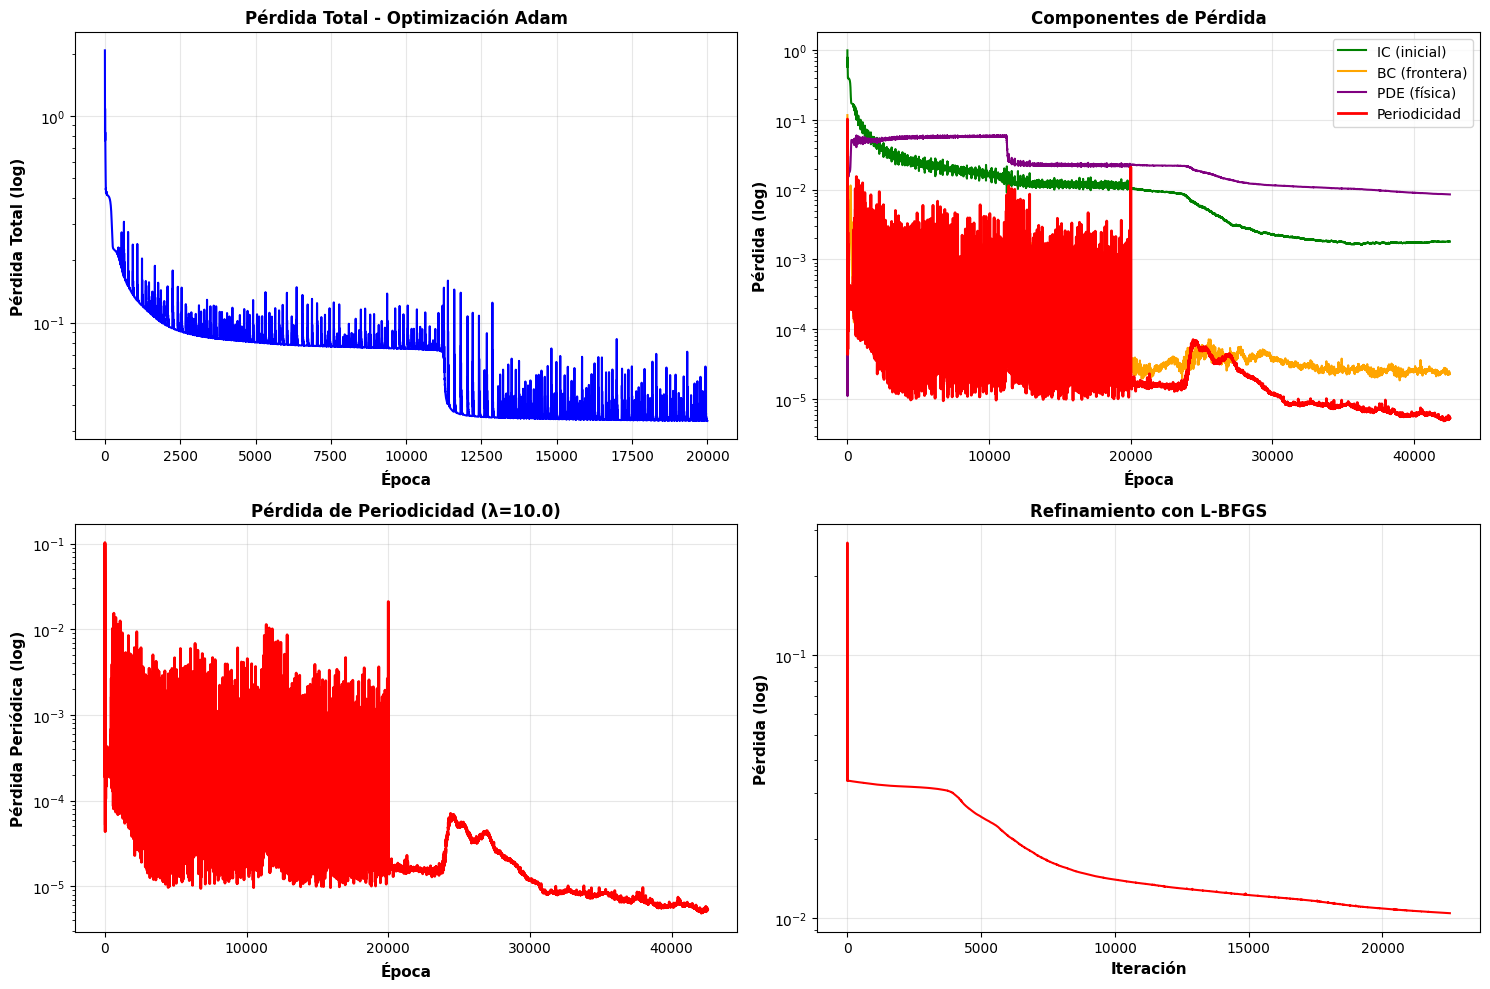

Gráfica guardada: NLS_PeriodicLoss_PINN_Training.png


In [11]:
# =====================================================================
# ANÁLISIS DE COMPONENTES DE PÉRDIDA
# =====================================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Pérdida total (Adam)
ax1.plot(model.loss_adam, 'b-', linewidth=1.5)
ax1.set_yscale('log')
ax1.set_xlabel('Época', fontsize=11, fontweight='bold')
ax1.set_ylabel('Pérdida Total (log)', fontsize=11, fontweight='bold')
ax1.set_title('Pérdida Total - Optimización Adam', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Componentes de pérdida
ax2.plot(model.loss_components_history['ic'], 'g-', linewidth=1.5, label='IC (inicial)')
ax2.plot(model.loss_components_history['bc'], 'orange', linewidth=1.5, label='BC (frontera)')
ax2.plot(model.loss_components_history['pde'], 'purple', linewidth=1.5, label='PDE (física)')
ax2.plot(model.loss_components_history['periodic'], 'r-', linewidth=2, label='Periodicidad')
ax2.set_yscale('log')
ax2.set_xlabel('Época', fontsize=11, fontweight='bold')
ax2.set_ylabel('Pérdida (log)', fontsize=11, fontweight='bold')
ax2.set_title('Componentes de Pérdida', fontsize=12, fontweight='bold')
ax2.legend(frameon=True, fontsize=10)
ax2.grid(True, alpha=0.3)

# Pérdida periódica en detalle
ax3.plot(model.loss_components_history['periodic'], 'r-', linewidth=2)
ax3.set_yscale('log')
ax3.set_xlabel('Época', fontsize=11, fontweight='bold')
ax3.set_ylabel('Pérdida Periódica (log)', fontsize=11, fontweight='bold')
ax3.set_title(f'Pérdida de Periodicidad (λ={lambda_periodic})', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# L-BFGS
if len(model.loss_lbfgs) > 0:
    ax4.plot(model.loss_lbfgs, 'r-', linewidth=1.5)
    ax4.set_yscale('log')
    ax4.set_xlabel('Iteración', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Pérdida (log)', fontsize=11, fontweight='bold')
    ax4.set_title('Refinamiento con L-BFGS', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NLS_PeriodicLoss_PINN_Training.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: NLS_PeriodicLoss_PINN_Training.png")

In [12]:
# =====================================================================
# GUARDAR RESULTADOS
# =====================================================================

# Guardar arrays
np.savez_compressed('NLS_PeriodicLoss_PINN_results.npz',
    x=x,
    t=t,
    X=X_mesh,
    T=T_mesh,
    Exact_u=Exact_u,
    Exact_v=Exact_v,
    Exact_h=Exact_h,
    U_pred=U_pred,
    V_pred=V_pred,
    H_pred=H_pred,
    X_f=X_f,
    error_u=error_u,
    error_v=error_v,
    error_h=error_h,
    periodicity_error_u=periodicity_error_u_pred,
    periodicity_error_v=periodicity_error_v_pred,
    periodicity_error_h=periodicity_error_h_pred
)

# Guardar metadata
metadata = {
    'model_type': 'PINN with Explicit Periodic Loss',
    'equation': 'Nonlinear Schrödinger (NLS) N=2',
    'spatial_domain': [float(lb[0]), float(ub[0])],
    'temporal_domain': [float(lb[1]), float(ub[1])],
    'period': float(T_period),
    'architecture': layers,
    'lambda_periodic': float(lambda_periodic),
    'training_points': {
        'initial_condition': int(N0),
        'boundary': int(N_b),
        'collocation': int(N_f)
    },
    'errors': {
        'u_relative_L2': float(error_u),
        'v_relative_L2': float(error_v),
        'h_relative_L2': float(error_h),
        'periodicity_u': float(periodicity_error_u_pred),
        'periodicity_v': float(periodicity_error_v_pred),
        'periodicity_h': float(periodicity_error_h_pred)
    },
    'training_time_sec': float(elapsed),
    'device': str(device),
    'framework': 'PyTorch with Explicit Periodic Loss',
    'loss_explanation': 'Añade L_periodic = ||ψ(x,0) - ψ(x,T)||² a la función de pérdida',
    'loss_components': {
        'initial_condition': 'IC loss',
        'boundary_condition': 'BC loss (spatial periodicity)',
        'pde_residual': 'PDE residual loss',
        'temporal_periodicity': f'Weighted by λ={lambda_periodic}'
    }
}

with open('NLS_PeriodicLoss_PINN_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n{'='*60}")
print(f"RESULTADOS GUARDADOS")
print(f"{'='*60}")
print(f"Arrays:   NLS_PeriodicLoss_PINN_results.npz")
print(f"Metadata: NLS_PeriodicLoss_PINN_metadata.json")
print(f"Imágenes:")
print(f"  - NLS_PeriodicLoss_PINN_Results.png")
print(f"  - NLS_PeriodicLoss_PINN_Periodicity.png")
print(f"  - NLS_PeriodicLoss_PINN_Training.png")
print(f"{'='*60}\n")

print("\n✅ ¡PINN con pérdida explícita de periodicidad completada!")
print(f"\nMétodo: Forzar que ψ(x,0) ≈ ψ(x,T) mediante pérdida adicional")
print(f"Peso: λ_periodic = {lambda_periodic}")
print(f"\nErrores de periodicidad:")
print(f"  u: {periodicity_error_u_pred:.6e}")
print(f"  v: {periodicity_error_v_pred:.6e}")
print(f"  |ψ|: {periodicity_error_h_pred:.6e}")


RESULTADOS GUARDADOS
Arrays:   NLS_PeriodicLoss_PINN_results.npz
Metadata: NLS_PeriodicLoss_PINN_metadata.json
Imágenes:
  - NLS_PeriodicLoss_PINN_Results.png
  - NLS_PeriodicLoss_PINN_Periodicity.png
  - NLS_PeriodicLoss_PINN_Training.png


✅ ¡PINN con pérdida explícita de periodicidad completada!

Método: Forzar que ψ(x,0) ≈ ψ(x,T) mediante pérdida adicional
Peso: λ_periodic = 10.0

Errores de periodicidad:
  u: 5.234891e-03
  v: 7.106763e-02
  |ψ|: 5.214638e-03


# PINN con Pérdida Explícita de Periodicidad Temporal

## Concepto Principal

En lugar de codificar el tiempo de forma periódica (como en el enfoque de características de Fourier), este método **añade un término explícito a la función de pérdida** que fuerza que el estado al inicio y al final del periodo coincidan:

$$\mathcal{L}_{\text{periodic}} = \|\psi(x, 0) - \psi(x, T)\|^2$$

## Función de Pérdida Total

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{IC} + \mathcal{L}_{BC} + \mathcal{L}_{PDE} + \lambda_{\text{periodic}} \cdot \mathcal{L}_{\text{periodic}}$$

Donde:
- **$\mathcal{L}_{IC}$**: Pérdida de condición inicial en $t=0$
- **$\mathcal{L}_{BC}$**: Pérdida de condiciones de frontera espaciales (periodicidad en $x$)
- **$\mathcal{L}_{PDE}$**: Residuales de la ecuación NLS
- **$\mathcal{L}_{\text{periodic}}$**: Diferencia entre $\psi(x,0)$ y $\psi(x,T)$
- **$\lambda_{\text{periodic}}$**: Hiperparámetro que controla la importancia de la periodicidad

## Ventajas

1. ✅ **Simplicidad**: No requiere modificar la arquitectura de la red
2. ✅ **Control directo**: El parámetro $\lambda$ permite ajustar la fuerza de la periodicidad
3. ✅ **Interpretable**: La pérdida tiene significado físico claro
4. ✅ **Flexible**: Funciona con cualquier periodo $T$

## Implementación

La pérdida periódica incluye tres componentes:

```python
# Amplitud
loss_periodic_amplitude = ||sqrt(u² + v²)|_{t=0} - sqrt(u² + v²)|_{t=T}||²

# Parte real
loss_periodic_real = ||u(x,0) - u(x,T)||²

# Parte imaginaria
loss_periodic_imag = ||v(x,0) - v(x,T)||²
```

Esto asegura que tanto la magnitud como la fase se conserven periódicamente.